In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import os
import pickle
from scipy import stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *

np.random.seed(666) # Need to do more to ensure data is the same across runs.
w = 3.5
h = 3.25              # Plots have dimension (w,h)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-08-15 05:28:48.272104: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-15 05:28:48.298510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:81:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-15 05:28:48.298693: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-15 05:28:48.300076: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-15 05:28:48.301723: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-15 05:28:48.301947: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

# Simple

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0    # bkgd: normal(-0.1, 1)     sgnl: normal(0.1, 1)
reps = 20

# File parameters
dirstr = 'models/univariate/simple/ab_mse/set_{}/'.format(num)
filestr = dirstr + 'model_{}_{}.h5'

if not os.path.isdir(dirstr):
    os.mkdir(dirstr)

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)
ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(dirstr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 1)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_simple.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0 
reps = 20

# Model parameters
dirstr = 'models/univariate/simple/ab_sqr/set_{}/'.format(num)
filestr_1 = dirstr + 'relu/model_{}_{}.h5'
filestr_2 = dirstr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(dirstr + 'lin_avgs.npy')
exp_avgs = np.load(dirstr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_simple.png', 
            dpi=300, 
            bbox_inches='tight')

# Normal

## Naïve Implementation

In [ ]:
# Experiment parameters
num = 0
reps = 100
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'relu'}
sqr_params = {'loss':sqr, 'output':'relu'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

### Likelihood Ratios

#### Process

#### Plot

In [ ]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')

In [ ]:
ratio_plot([bce_preds, mse_preds, mlc_preds, sqr_preds],
           ['BCE', 'MSE', 'MLC', 'SQR'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it Na\"ive Implementation',
           filename = 'plots/paper/naive_fit.png')

### MAEs

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')

In [ ]:
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR'],
         Ns,
         figsize = (w, h),
         title = r'\it Na\"ive Implementation'),
         filename = 'plots/paper/naive_sizes.png')

## $C$ Parametrization

### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_bce.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mse.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mlc.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_sqr.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## $A$/$B$ Parametrization

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr.png', 
            dpi=300, 
            bbox_inches='tight')

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse.png', 
            dpi=300, 
            bbox_inches='tight')

## Optimized Implementation

In [ ]:
num = 3
reps = 100
Ns = 10**np.arange(2, 8)

mu = 0.1
bkgd = stats.norm(-mu, 1)
sgnl = stats.norm(mu, 1)

mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
lr = make_lr(bkgd, sgnl)

# Model parameters
p = 1.24
r = 0.018
bce_params = {'loss':bce}
mse_params = {'loss':get_mse(p)}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':get_exp_sqr(r), 'output':'linear'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

### Likelihood Ratios

#### Process

In [ ]:
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model, m, s)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(N, i))
    mse_lrs[i] = pow_odds_lr(mse_model, p, m, s)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(N, i))
    mlc_lrs[i] = exp_lr(mlc_model, m, s)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(N, i))
    sqr_lrs[i] = pow_exp_lr(sqr_model, r, m, s)

xs = np.linspace(-6, 6, 1201)

bce_preds = get_preds(bce_lrs, xs)
mse_preds = get_preds(mse_lrs, xs)
mlc_preds = get_preds(mlc_lrs, xs)
sqr_preds = get_preds(sqr_lrs, xs)

In [ ]:
np.save(filestr + 'xs', xs)
np.save(filestr + 'bce_preds', bce_preds)
np.save(filestr + 'mse_preds', mse_preds)
np.save(filestr + 'mlc_preds', mlc_preds)
np.save(filestr + 'sqr_preds', sqr_preds)

#### Plot

In [ ]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')

In [ ]:
ratio_plot([bce_preds, mse_preds, mlc_preds, sqr_preds],
           ['BCE', 'MSE', 'MLC', 'SQR'],
           lr,
           bkgd, sgnl,
           xs,
           figsize = (w, h),
           title = r'\it Optimized Implementation',
           filename = 'plots/paper/best_fit_3.png')

### MAEs

#### Process

In [ ]:
X = np.load('data/normal/0.1/X_trn.npy')
y = np.load('data/normal/0.1/y_trn.npy')

# Calculate mean absolute errors
bce_avg = []
mse_avg = []
mlc_avg = []
sqr_avg = []

for N in Ns:
    print(N)
    data, m, s = split_data(X, y)
    
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, i))
        mse_lrs[i] = pow_odds_lr(mse_model, p, m, s)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, i))
        mlc_lrs[i] = exp_lr(mlc_model, m, s)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, i))
        sqr_lrs[i] = pow_exp_lr(sqr_model, r, m, s)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_avg += [np.mean(bce_maes)]
    mse_avg += [np.mean(mse_maes)]
    mlc_avg += [np.mean(mlc_maes)]
    sqr_avg += [np.mean(sqr_maes)]

bce_avg = np.array(bce_avg)
mse_avg = np.array(mse_avg)
mlc_avg = np.array(mlc_avg)
sqr_avg = np.array(sqr_avg)

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'mse_avg', mse_avg)
np.save(filestr + 'mlc_avg', mlc_avg)
np.save(filestr + 'sqr_avg', sqr_avg)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')

In [ ]:
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR'],
         Ns,
         figsize = (w, h),
         title = r'\it Optimized Implementation',
         filename = 'plots/paper/normal/best_sizes_3.png')

# Shifting Normals

## $A/B$ Parametrization

### $0.2$

#### MSE $A/B$ Parametrization

In [25]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.2/X_trn.npy')[:N]
y = np.load('data/normal/0.2/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.2, 1)
sgnl = stats.norm(+0.2, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.2/')

##### Process

##### MAEs

In [28]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.24])

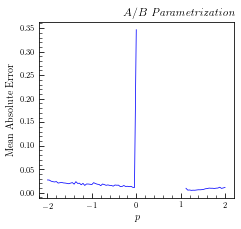

In [29]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.2.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [30]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.2/X_trn.npy')[:N]
y = np.load('data/normal/0.2/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.2, 1)
sgnl = stats.norm(+0.2, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.2/')

##### Process

##### MAEs

In [33]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([0.8]), array([0.03]))

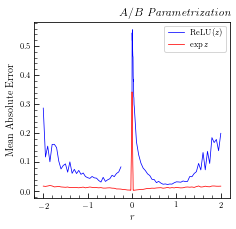

In [34]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.2.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.3$

#### MSE $A/B$ Parametrization

In [35]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.3/X_trn.npy')[:N]
y = np.load('data/normal/0.3/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.3, 1)
sgnl = stats.norm(+0.3, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.3/')

##### Process

##### MAEs

In [38]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.56])

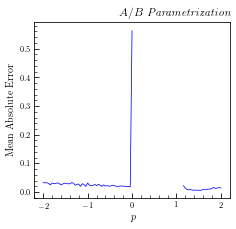

In [39]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.3.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [40]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.3/X_trn.npy')[:N]
y = np.load('data/normal/0.3/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.3, 1)
sgnl = stats.norm(+0.3, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.3/')

##### Process

##### MAEs

In [43]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([1.2]), array([0.05]))

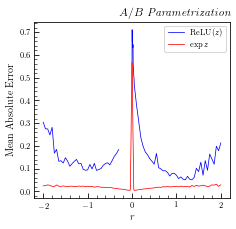

In [44]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.3.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.4$

#### MSE $A/B$ Parametrization

In [45]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.4/X_trn.npy')[:N]
y = np.load('data/normal/0.4/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.4, 1)
sgnl = stats.norm(+0.4, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.4/')

##### Process

##### MAEs

In [48]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.64])

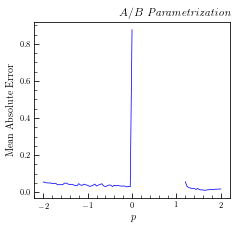

In [49]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.4.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [4]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.4/X_trn.npy')[:N]
y = np.load('data/normal/0.4/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.4, 1)
sgnl = stats.norm(+0.4, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.4/')

##### Process

In [5]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

-2.0	

2022-08-15 05:30:06.463024: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-08-15 05:30:06.471569: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994530000 Hz
2022-08-15 05:30:06.472800: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5611d3768040 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-15 05:30:06.472824: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-15 05:30:06.596552: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5611d37d1e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-15 05:30:06.596589: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2022-08-15 05:30:06.598101: I 

-1.95	-1.9	-1.85	-1.8	-1.75	-1.7	-1.65	-1.6	-1.55	-1.5	-1.45	-1.4	-1.35	-1.3	-1.25	-1.2	-1.15	-1.1	-1.05	-1.0	-0.95	-0.9	-0.85	-0.8	-0.75	-0.7	-0.65	-0.6	-0.55	-0.5	-0.45	-0.4	-0.35	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:202: RuntimeWarning: divide by zero encountered in power
  return np.squeeze(f**p)


-0.3	-0.25	-0.2	-0.15	-0.1	-0.05	-0.046	-0.042	-0.038	-0.034	-0.03	-0.026	-0.022	-0.018	-0.014	-0.01	-0.006	-0.002	0.0	0.002	0.006	0.01	0.014	0.018	0.022	0.026	0.03	0.034	0.038	0.042	0.046	0.05	0.1	0.15	0.2	0.25	0.3	0.35	0.4	0.45	0.5	0.55	0.6	0.65	0.7	0.75	0.8	0.85	0.9	0.95	1.0	1.05	1.1	1.15	1.2	1.25	1.3	1.35	1.4	1.45	1.5	1.55	1.6	1.65	1.7	1.75	1.8	1.85	1.9	1.95	2.0	

In [6]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [7]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([1.6]), array([0.1]))

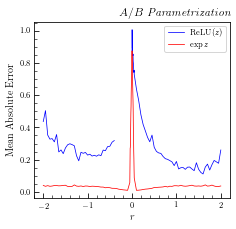

In [8]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.4.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.5$

#### MSE $A/B$ Parametrization

In [9]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.5/X_trn.npy')[:N]
y = np.load('data/normal/0.5/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.5, 1)
sgnl = stats.norm(+0.5, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.5/')

##### Process

In [10]:
# Get model likelihood ratios.
avgs = []
for p in ps:
    print(p, end = '\t')
    lrs = [None] * reps
    params = {'loss':get_mse(p)}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, i))
        lrs[i] = pow_odds_lr(model, p, m, s)
    
    maes = [mae(lr) for lr in lrs]
    avgs += [np.mean(maes)]

avgs = np.array(avgs)

-2.0	-1.96	-1.92	-1.88	-1.84	-1.8	-1.76	-1.72	-1.68	-1.64	-1.6	-1.56	-1.52	-1.48	-1.44	-1.4	-1.36	-1.32	-1.28	-1.24	-1.2	-1.16	-1.12	-1.08	-1.04	-1.0	-0.96	-0.92	-0.88	-0.84	-0.8	-0.76	-0.72	-0.68	-0.64	-0.6	-0.56	-0.52	-0.48	-0.44	-0.4	-0.36	-0.32	-0.28	-0.24	-0.2	-0.16	-0.12	-0.08	-0.04	0.0	0.04	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:214: RuntimeWarning: divide by zero encountered in true_divide
  return np.squeeze( (f / (1. - f))**(p - 1))
/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:214: RuntimeWarning: divide by zero encountered in power
  return np.squeeze( (f / (1. - f))**(p - 1))


0.08	0.12	0.16	0.2	0.24	0.28	0.32	0.36	0.4	0.44	0.48	0.52	0.56	0.6	0.64	0.68	0.72	0.76	0.8	0.84	0.88	0.92	0.96	1.0	1.04	1.08	1.12	1.16	1.2	1.24	1.28	1.32	1.36	1.4	1.44	1.48	1.52	1.56	1.6	1.64	1.68	1.72	1.76	1.8	1.84	1.88	1.92	1.96	2.0	

In [11]:
# Save results
np.save(filestr + 'avgs', avgs)

##### MAEs

In [12]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.88])

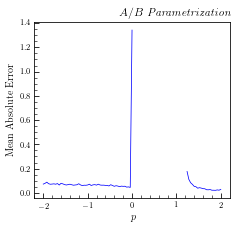

In [13]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.5.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [14]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.5/X_trn.npy')[:N]
y = np.load('data/normal/0.5/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.5, 1)
sgnl = stats.norm(+0.5, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.5/')

##### Process

In [15]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

-2.0	-1.95	-1.9	-1.85	-1.8	-1.75	-1.7	-1.65	-1.6	-1.55	-1.5	-1.45	-1.4	-1.35	-1.3	-1.25	-1.2	-1.15	-1.1	-1.05	-1.0	-0.95	-0.9	-0.85	-0.8	-0.75	-0.7	-0.65	-0.6	-0.55	-0.5	-0.45	-0.4	-0.35	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:202: RuntimeWarning: divide by zero encountered in power
  return np.squeeze(f**p)


-0.3	-0.25	-0.2	-0.15	-0.1	-0.05	-0.046	-0.042	-0.038	-0.034	-0.03	-0.026	-0.022	-0.018	-0.014	-0.01	-0.006	-0.002	0.0	0.002	0.006	0.01	0.014	0.018	0.022	0.026	0.03	0.034	0.038	0.042	0.046	0.05	0.1	0.15	0.2	0.25	0.3	0.35	0.4	0.45	0.5	0.55	0.6	0.65	0.7	0.75	0.8	0.85	0.9	0.95	1.0	1.05	1.1	1.15	1.2	1.25	1.3	1.35	1.4	1.45	1.5	1.55	1.6	1.65	1.7	1.75	1.8	1.85	1.9	1.95	2.0	

In [16]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [17]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([1.7]), array([0.1]))

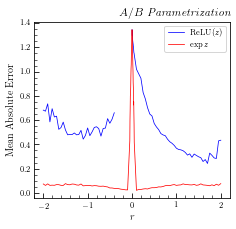

In [18]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.5.png', 
            dpi=300, 
            bbox_inches='tight')

# Beta

## $C$ Parametrizations

### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/beta/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (8, 8),
           title = r'\it $C$ Parametrization')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/beta/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mse_beta.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/beta/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratio

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mlc_beta.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/beta/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_sqr_beta.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 5
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_beta.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 5
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_beta.png', 
            dpi=300, 
            bbox_inches='tight')

# Gamma

## $C$ Parametrizations

### BCE $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_bce_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mse_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_mlc_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrizations

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
xs = np.linspace(0, 20, 1201)
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'xs.npy', xs)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [ ]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           bkgd, sgnl,
           xs,
           y_lim = (0, 10),
           figsize = (w, h),
           title = r'\it $C$ Parametrization',
           filename = 'plots/paper/c_sqr_gamma.png')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_gamma.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_gamma.png', 
            dpi=300, 
            bbox_inches='tight')

# Multivariate Normal

## Naïve Implementation

### Case 0

### Case 1

### Case 2

### Case 3

### Case 4

## $C$ Parametrization

In [ ]:
w = 3.5
h = 2.8

g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

### Case 0

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### Case 1

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### Case 2

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### Case 3

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_hyperbola_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_hyperbola_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_hyperbola_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_hyperbola_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_hyperbola_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_hyperbola_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### Case 4

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_checker_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_checker_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_checker_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_checker_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_checker_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_checker_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## $A/B$ Parametrization

### Case 0

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_vertical.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_vertical.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 1

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_slant.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [9]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### MAEs

In [12]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([0.35]), array([0.018]))

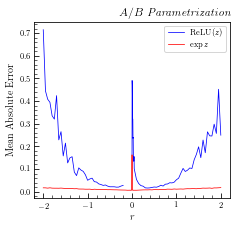

In [13]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_slant.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 2

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_circle.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [14]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### MAEs

In [17]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([-0.3]), array([-0.1]))

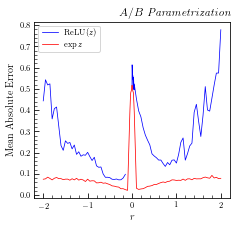

In [18]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_circle.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 3

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_hyperbola.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [19]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

##### MAEs

In [22]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([1.4]), array([-0.2]))

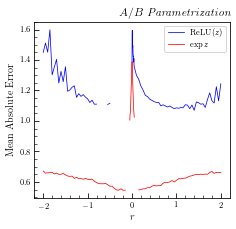

In [23]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_hyperbola.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 4

#### MSE $A/B$ Parametrization

In [4]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### MAEs

In [7]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.6])

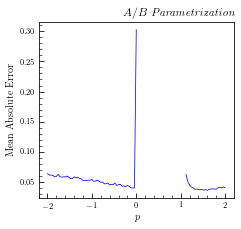

In [8]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_checker.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [19]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [20]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'd': 2, 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'd': 2, 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

-2.0	-1.95	-1.9	-1.85	-1.8	-1.75	-1.7	-1.65	-1.6	-1.55	-1.5	-1.45	-1.4	-1.35	-1.3	-1.25	-1.2	-1.15	-1.1	-1.05	-1.0	-0.95	-0.9	-0.85	-0.8	-0.75	-0.7	-0.65	-0.6	-0.55	-0.5	-0.45	

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:202: RuntimeWarning: divide by zero encountered in power
  return np.squeeze(f**p)


-0.4	-0.35	-0.3	-0.25	-0.2	-0.15	-0.1	-0.05	-0.046	-0.042	-0.038	-0.034	-0.03	-0.026	-0.022	-0.018	-0.014	-0.01	-0.006	-0.002	0.0	0.002	0.006	0.01	0.014	0.018	0.022	0.026	0.03	0.034	0.038	0.042	0.046	0.05	0.1	0.15	0.2	0.25	0.3	0.35	0.4	0.45	0.5	0.55	0.6	0.65	0.7	0.75	0.8	0.85	0.9	0.95	1.0	1.05	1.1	1.15	1.2	1.25	1.3	1.35	1.4	1.45	1.5	1.55	1.6	1.65	1.7	1.75	1.8	1.85	1.9	1.95	2.0	

In [21]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [22]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([-0.65]), array([-0.1]))

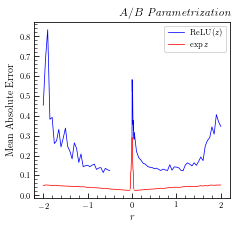

In [23]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_checker.png', 
            dpi=300, 
            bbox_inches='tight')